## Un-conditional Diffusion Model implementation with UNET architecture

In [1]:
# Import libraries
import os
import math
import itertools
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/Users/amit/Documents/Projects/diffusion-models-from-scratch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 3. CIFAR-10 subset dataloader

This helper function builds a small subset of CIFAR-10 and wraps it in a PyTorch `DataLoader`.

- It uses a transform that:
  1. Resizes images to a square size `image_size`  
  2. Converts them to tensors in `[0, 1]`  
  3. Linearly rescales them to `[-1, 1]` using $x_{\text{norm}} = 2x - 1$

This range is standard for diffusion models since the forward process often assumes images lie in \([-1, 1]\).

We restrict ourselves to the first `num_samples` images for faster experiments.


In [3]:
# -------------------------------------------------------
# CIFAR-10 subset loader
# -------------------------------------------------------

def get_image_subset_dataloader(
    num_samples: int = 500,
    batch_size: int = 64,
    image_size: int = 32,
):
    """
    Create a DataLoader over a small subset of CIFAR-10 (num_samples images).
    Images are resized and normalized to [-1, 1], which is standard for diffusion models.
    """

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),                    # -> [0,1]
        transforms.Lambda(lambda t: t * 2 - 1),   # -> [-1,1]
    ])

    dataset_train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transform,
    )

    # Pick the first num_samples images
    indices = list(range(min(num_samples, len(dataset_train))))
    subset = Subset(dataset_train, indices)

    loader = DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader

## Visualizing a batch of CIFAR-10 images

Here we:

1. Create a dataloader with 500 CIFAR-10 images.
2. Pull a single batch of images and labels.
3. Map the images from `[-1, 1]` back to `[0, 1]`: $x_{\text{vis}} = \frac{x + 1}{2} $
4. Plot 8 images in a row, showing their class labels as titles.

This is mainly a sanity check that our data pipeline works correctly.


Files already downloaded and verified
Batch images shape: torch.Size([16, 3, 32, 32])
Batch labels shape: torch.Size([16])


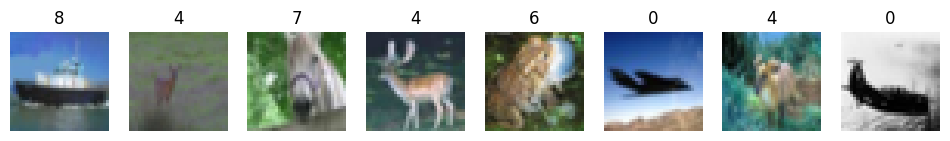

In [4]:
# Load a CIFAR-10 subset
cifar_loader = get_image_subset_dataloader(
    num_samples=500,
    batch_size=16,
    image_size=32,
)

# Get one batch
images, labels = next(iter(cifar_loader))
print("Batch images shape:", images.shape)   # (B, 3, 32, 32)
print("Batch labels shape:", labels.shape)

# Convert from [-1,1] back to [0,1] for visualization
images_vis = (images[:8] + 1) / 2

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    # Convert from (C, H, W) to (H, W, C) for imshow
    img = images_vis[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(labels[i].item())
    axes[i].axis("off")

plt.show()

## DDPM noise scheduler

The diffusion process uses a sequence of noise scales defined by $\beta_t$ values.

From $\beta_t$ we define:

- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=0}^t \alpha_s$

The forward process (noising) for a clean image $x_0$ is:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 
    + \sqrt{1 - \bar{\alpha}_t}\, \epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I)
$$

The reverse process uses a learned model $\epsilon_\theta(x_t, t)$ 
and a closed-form Gaussian posterior to sample $x_{t-1}$ from $x_t$.

This class:

- Precomputes $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$, and $\bar{\alpha}_{t-1}$
- Implements `add_noise` (forward diffusion).
- Implements `step` (one reverse diffusion step).

We keep the implementation simple and only broadcast scalars to image shapes when needed.

In [5]:
# -------------------------------------------------------
# Simple DDPM noise scheduler (no helpers)
# -------------------------------------------------------

class DDPMScheduler:
    """
    Simple beta schedule and forward / reverse diffusion steps for DDPM.

    beta_t in (0,1)
    alpha_t = 1 - beta_t
    alpha_bar_t = ∏_{s=0}^t alpha_s
    """

    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 2e-2,
    ):
        self.num_timesteps = num_timesteps

        # All are simple 1D tensors on CPU by default
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        # alpha_bar_{-1} is defined as 1
        alpha_bars_prev = torch.cat(
            [torch.tensor([1.0], dtype=torch.float32), self.alpha_bars[:-1]], dim=0
        )
        self.alpha_bars_prev = alpha_bars_prev

    def _expand_for_broadcast(self, values_1d: torch.Tensor, like: torch.Tensor) -> torch.Tensor:
        """
        Expand a 1D tensor of shape (B,) so it can broadcast with 'like' (e.g. image tensors).
        After this, values_1d will have shape (B, 1, 1, 1) when 'like' is (B, C, H, W).
        """
        while values_1d.dim() < like.dim():
            values_1d = values_1d.unsqueeze(-1)
        return values_1d

    def add_noise(
        self, x0: torch.Tensor, timesteps: torch.LongTensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward diffusion:
        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * eps, where eps ~ N(0, I)
        """
        device = x0.device

        # Move indices to CPU for indexing and then the result to the correct device
        alpha_bar_t = self.alpha_bars[timesteps.cpu()].to(device)        # (B,)
        alpha_bar_t = self._expand_for_broadcast(alpha_bar_t, x0)        # (B,1,1,1) for images

        # Sample noise with same shape and device as x0
        eps = torch.randn_like(x0)

        mean = alpha_bar_t.sqrt() * x0
        std = (1.0 - alpha_bar_t).sqrt()
        x_t = mean + std * eps
        return x_t, eps

    def step(
        self,
        x_t: torch.Tensor,
        timesteps: torch.LongTensor,
        eps_pred: torch.Tensor,
    ) -> torch.Tensor:
        """
        One reverse diffusion step: sample x_{t-1} from p(x_{t-1} | x_t).

        Mean term:
        μ_t(x_t, ε̂) =
        1 / sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * ε̂)

        Variance term:
        σ_t^2 =
        beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
        """
        assert x_t.shape == eps_pred.shape

        device = x_t.device
        bsz = x_t.size(0)
        t = timesteps

        # Move indices to CPU for indexing the precomputed 1D tensors
        t_cpu = t.cpu()

        beta_t = self.betas[t_cpu].to(device)                  # (B,)
        alpha_t = self.alphas[t_cpu].to(device)                # (B,)
        alpha_bar_t = self.alpha_bars[t_cpu].to(device)        # (B,)
        alpha_bar_prev_t = self.alpha_bars_prev[t_cpu].to(device)  # (B,)

        beta_t = self._expand_for_broadcast(beta_t, x_t)
        alpha_t = self._expand_for_broadcast(alpha_t, x_t)
        alpha_bar_t = self._expand_for_broadcast(alpha_bar_t, x_t)
        alpha_bar_prev_t = self._expand_for_broadcast(alpha_bar_prev_t, x_t)

        # Mean term
        noise_coeff = beta_t / (1.0 - alpha_bar_t).sqrt()
        mean = (1.0 / alpha_t.sqrt()) * (x_t - noise_coeff * eps_pred)

        # Variance term
        posterior_var_t = beta_t * (1.0 - alpha_bar_prev_t) / (1.0 - alpha_bar_t)
        posterior_std_t = posterior_var_t.clamp(min=1e-20).sqrt()

        # Sample new noise and mask it out when t == 0
        noise = torch.randn_like(x_t)
        nonzero_mask = (t > 0).float().view(bsz, *([1] * (x_t.dim() - 1))).to(device)
        x_prev = mean + nonzero_mask * posterior_std_t * noise
        return x_prev


## Visualizing the effect of the scheduler on CIFAR images

This function samples a small batch from the CIFAR loader, applies the forward diffusion step at random timesteps, and displays:

- A row of **clean images**  
- A row of **noisy images** at various timesteps  

To undo the normalization for plotting, we apply

$$
x_{\text{vis}} = \frac{x + 1}{2}
$$

so that values are in \([0,1]\).


Files already downloaded and verified


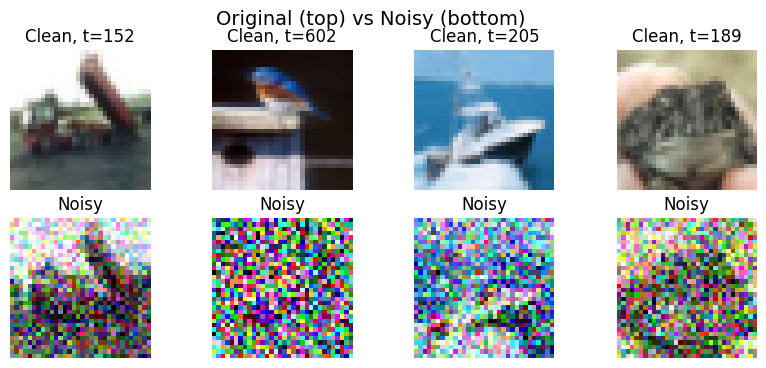

In [6]:
def demo_scheduler_noise_visualization():
    """
    Simple visualization: original vs noised CIFAR-10 images.
    Shows clean images and their noised versions at random timesteps.
    """
    loader = get_image_subset_dataloader(num_samples=32, batch_size=8)
    images, _ = next(iter(loader))
    images = images.to(device)

    scheduler = DDPMScheduler(num_timesteps=1000)
    timesteps = torch.randint(0, scheduler.num_timesteps, (images.size(0),), device=device)

    noisy_images, _ = scheduler.add_noise(images, timesteps)

    # Map from [-1, 1] -> [0, 1] and clamp for safe visualization
    images_cpu = ((images[:4].detach().cpu() + 1.0) / 2.0).clamp(0.0, 1.0)
    noisy_cpu = ((noisy_images[:4].detach().cpu() + 1.0) / 2.0).clamp(0.0, 1.0)

    fig, axes = plt.subplots(2, 4, figsize=(10, 4))
    fig.suptitle("Original (top) vs Noisy (bottom)", fontsize=14)

    for i in range(4):
        # Plot clean RGB image
        axes[0, i].imshow(images_cpu[i].permute(1, 2, 0))
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Clean, t={timesteps[i].item()}")

        # Plot corresponding noisy image
        axes[1, i].imshow(noisy_cpu[i].permute(1, 2, 0))
        axes[1, i].axis("off")
        axes[1, i].set_title("Noisy")

    plt.show()

# Optional: run once to check
demo_scheduler_noise_visualization()

## Single head self attention

Self attention allows each token in a sequence to attend to all other tokens.

Given an input sequence $X \in \mathbb{R}^{L \times d}$, we compute:

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
$$

$$
\text{Scores} = \frac{QK^\top}{\sqrt{d}},\quad
\text{Weights} = \text{softmax}(\text{Scores})
$$

$$
\text{Attention}(X) = \text{Weights} \cdot V
$$

This class implements **single head** attention with a single set of \(W_Q, W_K, W_V\).


In [7]:
# -------------------------------------------------------
# Attention blocks
# -------------------------------------------------------

class SingleHeadSelfAttention(nn.Module):
    """
    Simple single head self attention block.
    Input:  (batch, seq_len, embed_dim)
    Output: (batch, seq_len, embed_dim)
    """

    def __init__(self, embed_dim: int):
        super().__init__()
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        bsz, seq_len, dim = x.shape

        # Project input to queries, keys, values
        q = self.query(x)  # (B, L, D)
        k = self.key(x)    # (B, L, D)
        v = self.value(x)  # (B, L, D)

        # Scaled dot product attention
        scale = dim ** -0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, L, L)
        weights = scores.softmax(dim=-1)                       # (B, L, L)
        out = torch.matmul(weights, v)                         # (B, L, D)
        return out

## Multi-Head Self-Attention

Multi-head self-attention splits the embedding dimension into $h$ heads, each of size $d_h = d / h$.

For each head $i$:

$$
\text{head}_i = \text{Attention}(X W_Q^{(i)},\, X W_K^{(i)},\, X W_V^{(i)})
$$

The outputs are concatenated and passed through an output projection:

$$
\text{MHA}(X) = W_O \cdot \text{concat}(\text{head}_1, \dots, \text{head}_h)
$$

This allows the model to attend to multiple types of relationships in parallel.

In [8]:
class MultiHeadSelfAttention(nn.Module):
    """
    Multi head self attention used in the UNet.
    Input:  (batch, seq_len, embed_dim)
    Output: (batch, seq_len, embed_dim)
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int = 4,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = attn_dropout
        self.proj_dropout = nn.Dropout(proj_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        bsz, seq_len, dim = x.shape

        # Project tokens to queries, keys, values
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        def split_heads(t):
            # (B, L, D) -> (B, H, L, head_dim)
            return t.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        q = split_heads(q)
        k = split_heads(k)
        v = split_heads(v)

        # Scaled dot product attention per head
        scale = self.head_dim ** -0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, H, L, L)
        weights = scores.softmax(dim=-1)
        if self.attn_dropout > 0.0 and self.training:
            weights = F.dropout(weights, p=self.attn_dropout)

        out = torch.matmul(weights, v)                          # (B, H, L, head_dim)

        # Merge heads back to (B, L, D)
        out = out.transpose(1, 2).contiguous().view(bsz, seq_len, dim)
        out = self.out_proj(out)
        out = self.proj_dropout(out)
        return out

## 9. Feed-forward MLP block

Transformer blocks typically include an MLP after attention.

Given input \(x\), a standard form is:

$$
\text{MLP}(x) = W_2 \,\sigma(W_1 x)
$$

where $\sigma$ is a nonlinearity such as GELU.

This block expands the embedding dimension by `mlp_ratio` and then projects back.


In [9]:
class FeedForwardMLP(nn.Module):
    """
    Simple MLP used in transformer blocks.
    """

    def __init__(self, embed_dim: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

## Transformer block over spatial feature maps

To apply self attention to image feature maps:

1. Treat each spatial location as a token.
2. Flatten \((H, W)\) into a sequence of length $H \cdot W$.
3. Apply multi head self attention and an MLP.
4. Reshape back to \((C, H, W)\).

This block:

- Normalizes along the channel dimension with `LayerNorm`.
- Applies a `MultiHeadSelfAttention`.
- Applies a `FeedForwardMLP`.
- Uses residual connections around both sub-blocks.

Input and output shapes are `(B, C, H, W)`.


In [10]:
class TransformerSpatialBlock(nn.Module):
    """
    Transformer block that operates on spatial feature maps by
    flattening (H, W) into a sequence and using multi head attention.

    Input / output: (B, C, H, W)
    """

    def __init__(
        self,
        channels: int,
        num_heads: int = 4,
        mlp_ratio: float = 2.0,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        mlp_dropout: float = 0.0,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(channels, eps=1e-6)
        self.attn = MultiHeadSelfAttention(
            embed_dim=channels,
            num_heads=num_heads,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
        )
        self.norm2 = nn.LayerNorm(channels, eps=1e-6)
        self.mlp = FeedForwardMLP(
            embed_dim=channels,
            mlp_ratio=mlp_ratio,
            dropout=mlp_dropout,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape

        # Reshape to sequence: (B, C, H, W) -> (B, HW, C)
        x_seq = x.view(b, c, h * w).permute(0, 2, 1)

        # Attention with residual connection
        x_seq = x_seq + self.attn(self.norm1(x_seq))

        # MLP with residual connection
        x_seq = x_seq + self.mlp(self.norm2(x_seq))

        # Restore spatial layout
        x = x_seq.permute(0, 2, 1).view(b, c, h, w)
        return x

## 11. Attention shape sanity check

This helper function creates a random sequence and passes it through:

- Single head self attention  
- Multi head self attention  

We print input and output shapes to confirm that attention layers preserve the shape `(batch, seq_len, embed_dim)`.

In [11]:
def demo_attention_shapes():
    """
    Run both single head and multi head attention on random sequences and print shapes.
    """
    tokens = torch.randn(4, 16, 32)  # (batch, seq_len, embed_dim)

    single_head = SingleHeadSelfAttention(embed_dim=32)
    mhsa = MultiHeadSelfAttention(embed_dim=32, num_heads=4)

    out_single = single_head(tokens)
    out_multi = mhsa(tokens)

    print("Single head:", tokens.shape, "->", out_single.shape)
    print("Multi head:", tokens.shape, "->", out_multi.shape)

demo_attention_shapes()

Single head: torch.Size([4, 16, 32]) -> torch.Size([4, 16, 32])
Multi head: torch.Size([4, 16, 32]) -> torch.Size([4, 16, 32])


## 12. Sinusoidal time embeddings

The model needs a representation of the diffusion timestep $t$.

We use sinusoidal embeddings followed by an MLP:

1. Compute frequencies $\omega_k$ and: $\text{emb}(t)_k = \sin(\omega_k t),\quad
\text{emb}(t)_{k + d/2} = \cos(\omega_k t)$

2. Pass the concatenated vector through a small MLP to get the final time embedding.

This gives a smooth, unique representation for each timestep.


In [12]:
# -------------------------------------------------------
# Sinusoidal time embedding
# -------------------------------------------------------

class SinusoidalTimeEmbedding(nn.Module):
    """
    Sinusoidal embedding of scalar timesteps followed by a small MLP.

    Input:  timesteps: (batch,)
    Output: embeddings: (batch, out_dim)
    """

    def __init__(self, base_dim: int, out_dim: int):
        super().__init__()
        self.base_dim = base_dim

        half_dim = base_dim // 2
        freq = torch.exp(
            -math.log(10000.0) * torch.arange(0, half_dim, dtype=torch.float32) / half_dim
        )
        self.register_buffer("freq", freq)

        self.mlp = nn.Sequential(
            nn.Linear(base_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),
            nn.SiLU(),
        )

    def forward(self, timesteps: torch.LongTensor) -> torch.Tensor:
        """
        timesteps: (batch,)
        """
        t = timesteps.float().unsqueeze(1)             # (B, 1)
        freqs = t * self.freq.unsqueeze(0)             # (B, half_dim)
        emb = torch.cat([freqs.sin(), freqs.cos()], dim=-1)  # (B, base_dim)
        emb = self.mlp(emb)
        return emb


def demo_time_embedding():
    t = torch.tensor([0, 1, 10, 50])
    emb_layer = SinusoidalTimeEmbedding(base_dim=64, out_dim=256)
    out = emb_layer(t)
    print("Timesteps:", t.shape, "-> embeddings:", out.shape)

demo_time_embedding()

Timesteps: torch.Size([4]) -> embeddings: torch.Size([4, 256])


## UNet building blocks

We now define the basic components of a UNet backbone:

1. **ResidualBlock**  
   - Applies GroupNorm, SiLU, Conv  
   - Adds a projected time embedding  
   - Adds a residual connection

2. **DownSample**  
   - Uses a strided convolution to reduce spatial resolution by a factor of 2.

3. **UpSample**  
   - Uses nearest neighbor upsampling followed by a convolution to double spatial resolution.

These blocks are used to construct the encoder and decoder paths of the UNet.


In [13]:
# -------------------------------------------------------
# UNet building blocks
# -------------------------------------------------------

class ResidualBlock(nn.Module):
    """
    Residual block with GroupNorm and time embedding conditioning.

    x: (B, C, H, W)
    time_emb: (B, time_dim)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        time_emb_dim: int,
        num_groups: int = 16,
    ):
        super().__init__()

        # Project time embedding to match out_channels
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Skip connection to handle channel change
        self.skip = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x: torch.Tensor, time_emb: torch.Tensor) -> torch.Tensor:
        residual = self.skip(x)

        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Broadcast time embedding over spatial dimensions
        temb = self.time_mlp(time_emb)[:, :, None, None]
        h = h + temb

        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)

        return h + residual


In [14]:

class DownSample(nn.Module):
    """
    Downsample spatial resolution by a factor of 2 using a strided convolution.
    """

    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


In [15]:
class UpSample(nn.Module):
    """
    Upsample spatial resolution by a factor of 2 using nearest neighbor + conv.
    """

    def __init__(self, channels: int):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        x = self.conv(x)
        return x

## ResidualBlock shape sanity check

This helper function tests the `ResidualBlock` with dummy inputs:

- Random feature map `x` of shape `(B, C, H, W)`  
- Random time embedding `t_emb` of shape `(B, time_dim)`  

We verify that the output has the expected shape and that broadcasting of the time embedding works.


In [16]:
def demo_residual_block():
    x = torch.randn(4, 32, 16, 16)
    t_emb = torch.randn(4, 128)
    block = ResidualBlock(in_channels=32, out_channels=64, time_emb_dim=128)
    out = block(x, t_emb)
    print("ResidualBlock:", x.shape, "+ time_emb", t_emb.shape, "->", out.shape)

demo_residual_block()

ResidualBlock: torch.Size([4, 32, 16, 16]) + time_emb torch.Size([4, 128]) -> torch.Size([4, 64, 16, 16])


## UNet2D backbone

We construct a 2D UNet as the backbone for the diffusion model.

- **Encoder (down path)**:
  - Multiple `ResidualBlock`s at each resolution
  - Optional self attention at the lowest resolution
  - `DownSample` between resolutions
  - Stores skip connections

- **Bottleneck**:
  - Residual block
  - TransformerSpatialBlock attention
  - Residual block

- **Decoder (up path)**:
  - Concatenates skip features with current features
  - Residual blocks to fuse them
  - Optional attention at the lowest resolution
  - `UpSample` between resolutions

The UNet takes a noisy image and time embedding and outputs a noise prediction with the same shape as the input image.


In [17]:
# -------------------------------------------------------
# UNet backbone for diffusion model
# -------------------------------------------------------

class UNet2D(nn.Module):
    """
    A small 2D UNet backbone with optional attention at the lowest resolution.
    Designed to be easy to read and to work well on small images (e.g., CIFAR or MNIST).
    """

    def __init__(
        self,
        in_channels: int = 1,
        base_channels: int = 64,
        channel_multipliers: Tuple[int, ...] = (1, 2, 4),
        time_emb_dim: int = 256,
        num_res_blocks: int = 2,
        num_heads: int = 4,
        num_groups: int = 16,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.base_channels = base_channels

        # First convolution maps input channels to base_channels
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)

        channels = [base_channels * m for m in channel_multipliers]
        self.down_blocks = nn.ModuleList()
        in_ch = base_channels

        # Downsampling path
        for i, ch in enumerate(channels):
            res_blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                res_blocks.append(
                    ResidualBlock(
                        in_channels=in_ch,
                        out_channels=ch,
                        time_emb_dim=time_emb_dim,
                        num_groups=num_groups,
                    )
                )
                in_ch = ch

            # Use attention only at the lowest resolution
            use_attention = i == len(channels) - 1
            attn = (
                TransformerSpatialBlock(channels=in_ch, num_heads=num_heads)
                if use_attention
                else nn.Identity()
            )
            # Downsample between resolutions
            downsample = DownSample(in_ch) if i < len(channels) - 1 else nn.Identity()

            self.down_blocks.append(
                nn.ModuleDict(
                    {
                        "res_blocks": res_blocks,
                        "attn": attn,
                        "downsample": downsample,
                    }
                )
            )

        # Bottleneck
        bottleneck_channels = channels[-1]
        self.bottleneck = nn.ModuleDict(
            {
                "res1": ResidualBlock(
                    bottleneck_channels,
                    bottleneck_channels,
                    time_emb_dim=time_emb_dim,
                    num_groups=num_groups,
                ),
                "attn": TransformerSpatialBlock(
                    channels=bottleneck_channels, num_heads=num_heads
                ),
                "res2": ResidualBlock(
                    bottleneck_channels,
                    bottleneck_channels,
                    time_emb_dim=time_emb_dim,
                    num_groups=num_groups,
                ),
            }
        )

        # Upsampling path
        self.up_blocks = nn.ModuleList()
        for i in reversed(range(len(channels))):
            ch = channels[i]
            is_last = i == 0
            out_ch = base_channels if is_last else channels[i - 1]

            res_blocks = nn.ModuleList()
            # First block sees concatenation of skip and current features: ch + ch
            res_blocks.append(
                ResidualBlock(
                    in_channels=ch + ch,
                    out_channels=out_ch,
                    time_emb_dim=time_emb_dim,
                    num_groups=num_groups,
                )
            )
            # Remaining blocks keep out_ch channels
            for _ in range(num_res_blocks - 1):
                res_blocks.append(
                    ResidualBlock(
                        in_channels=out_ch,
                        out_channels=out_ch,
                        time_emb_dim=time_emb_dim,
                        num_groups=num_groups,
                    )
                )

            use_attention = i == len(channels) - 1
            attn = (
                TransformerSpatialBlock(channels=out_ch, num_heads=num_heads)
                if use_attention
                else nn.Identity()
            )

            upsample = UpSample(out_ch) if not is_last else nn.Identity()

            self.up_blocks.append(
                nn.ModuleDict(
                    {
                        "res_blocks": res_blocks,
                        "attn": attn,
                        "upsample": upsample,
                    }
                )
            )

        # Final projection back to in_channels (e.g. 3 for RGB)
        self.conv_out = nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, time_emb: torch.Tensor) -> torch.Tensor:
        # Initial projection
        x = self.conv_in(x)
        skips: List[torch.Tensor] = []

        # Down path: store skip connections
        for block in self.down_blocks:
            for res in block["res_blocks"]:
                x = res(x, time_emb)
            x = block["attn"](x)
            skips.append(x)
            x = block["downsample"](x)

        # Bottleneck
        x = self.bottleneck["res1"](x, time_emb)
        x = self.bottleneck["attn"](x)
        x = self.bottleneck["res2"](x, time_emb)

        # Up path: concatenate skip features and refine
        for block in self.up_blocks:
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            for res in block["res_blocks"]:
                x = res(x, time_emb)
            x = block["attn"](x)
            x = block["upsample"](x)

        x = self.conv_out(x)
        return x

## UNet2D shape sanity check

We pass a random tensor through the UNet and verify that:

- Input shape: `(B, C, H, W)`  
- Output shape: `(B, C, H, W)`  

This confirms that the UNet preserves spatial resolution and channel count.


In [18]:
def demo_unet_shapes():
    x = torch.randn(4, 3, 32, 32)
    t_emb = torch.randn(4, 256)
    unet = UNet2D(in_channels=3, base_channels=32, channel_multipliers=(1, 2), time_emb_dim=256)
    out = unet(x, t_emb)
    print("UNet2D:", x.shape, "->", out.shape)

demo_unet_shapes()

UNet2D: torch.Size([4, 3, 32, 32]) -> torch.Size([4, 3, 32, 32])


## Full diffusion model wrapper

The `DiffusionModel` class composes:

1. A `SinusoidalTimeEmbedding` that maps integer timesteps \(t\) to vectors.
2. A `UNet2D` backbone that predicts noise $\epsilon_\theta(x_t, t)$.

During training, we sample a timestep \(t\), construct \(x_t\) from a clean image, and minimize

$$
\mathcal{L} = \mathbb{E}\left[\lVert \epsilon - \epsilon_\theta(x_t, t) \rVert^2\right]
$$

where $\epsilon$ is the true noise used in the forward process.


In [19]:
# -------------------------------------------------------
# Full diffusion model wrapper
# -------------------------------------------------------

class DiffusionModel(nn.Module):
    """
    Wraps:
      - Sinusoidal time embedding
      - UNet2D backbone that predicts the noise epsilon
    """

    def __init__(
        self,
        in_channels: int = 1,
        base_channels: int = 64,
        channel_multipliers: Tuple[int, ...] = (1, 2, 4),
        time_base_dim: int = 64,
        time_hidden_dim: int = 256,
        num_res_blocks: int = 2,
        num_heads: int = 4,
        num_groups: int = 16,
    ):
        super().__init__()
        self.time_embedding = SinusoidalTimeEmbedding(
            base_dim=time_base_dim,
            out_dim=time_hidden_dim,
        )
        self.unet = UNet2D(
            in_channels=in_channels,
            base_channels=base_channels,
            channel_multipliers=channel_multipliers,
            time_emb_dim=time_hidden_dim,
            num_res_blocks=num_res_blocks,
            num_heads=num_heads,
            num_groups=num_groups,
        )

    def forward(self, x_t: torch.Tensor, timesteps: torch.LongTensor) -> torch.Tensor:
        # Embed timesteps and pass to the UNet
        time_emb = self.time_embedding(timesteps)
        eps_pred = self.unet(x_t, time_emb)
        return eps_pred


## DiffusionModel forward pass demo

Here we:

1. Load a small batch of CIFAR-10 images.
2. Detect the number of input channels (3 for RGB).
3. Create a `DDPMScheduler` and a `DiffusionModel`.
4. Add noise to the images at random timesteps.
5. Pass the noisy images through the model to get a noise prediction.

We print shapes to confirm:

- Clean images  
- Noisy images $x_t$ 
- True noise $\epsilon$ 
- Predicted noise $\epsilon_\theta$


In [20]:
def demo_diffusion_forward_pass():
    loader = get_image_subset_dataloader(
        num_samples=32,
        batch_size=8,
        image_size=32,
    )
    
    images, _ = next(iter(loader))
    images = images.to(device)   # shape: (B, 3, 32, 32) for CIFAR-10

    # Automatically detect number of channels (3 for CIFAR-10)
    in_channels = images.shape[1]

    # Use the simple scheduler 
    scheduler = DDPMScheduler(num_timesteps=1000)

    # Build diffusion model with correct input channels
    model = DiffusionModel(in_channels=in_channels).to(device)

    bsz = images.size(0)
    t = torch.randint(0, scheduler.num_timesteps, (bsz,), device=device)

    x_t, eps_true = scheduler.add_noise(images, t)
    eps_pred = model(x_t, t)

    print("Clean images:", images.shape)
    print("Noisy images:", x_t.shape)
    print("True noise:", eps_true.shape)
    print("Predicted noise:", eps_pred.shape)

# Run the demo
demo_diffusion_forward_pass()

Files already downloaded and verified
Clean images: torch.Size([8, 3, 32, 32])
Noisy images: torch.Size([8, 3, 32, 32])
True noise: torch.Size([8, 3, 32, 32])
Predicted noise: torch.Size([8, 3, 32, 32])


## Sampling and visualization

To generate images:

1. Start from Gaussian noise $x_T \sim \mathcal{N}(0, I)$.
2. For $t = T, T-1, \dots, 1$:
   - Predict noise $\epsilon_\theta(x_t, t)$.
   - Use the scheduler to sample $x_{t-1}$.

We visualize:

- Top row: final generated images at $t = 0$.  
- Bottom row: snapshots of the first image at several timesteps.

The helper `show_image` handles both grayscale and RGB images and clamps values to valid display ranges.


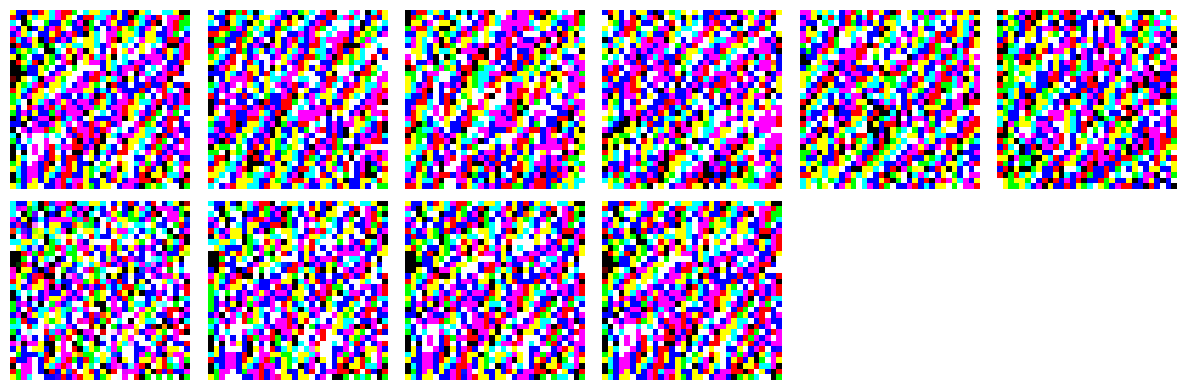

In [21]:
@torch.no_grad()
def sample_and_plot(
    model: DiffusionModel,
    scheduler: DDPMScheduler,
    num_images: int = 6,
    image_size: int = 32,
    num_steps: int = 1000,
    plot_every: int = 250,
    save_path: str = "samples.png",
):
    """
    Generate images by starting from noise and showing:
      Row 1: final generated images
      Row 2: intermediate samples across time

    Works for both 1-channel (grayscale) and 3-channel (RGB) models.
    """
    model.eval()
    model.to(device)

    # Infer the number of channels from the UNet
    try:
        in_channels = model.unet.in_channels
    except AttributeError:
        # Fallback if not available
        in_channels = 1

    # Start from random Gaussian noise with correct channels
    x_t = torch.randn(num_images, in_channels, image_size, image_size, device=device)

    # This will hold snapshots over time (for the first sample only)
    snapshots = []

    for t in reversed(range(num_steps)):
        t_batch = torch.full((num_images,), t, device=device, dtype=torch.long)
        eps_pred = model(x_t, t_batch)
        x_t = scheduler.step(x_t, t_batch, eps_pred)

        if t % plot_every == 0 or t == 0:
            snapshots.append(x_t[0].detach().cpu())

    # Final images to [0,1]
    final_images = (x_t.detach().cpu() + 1.0) / 2.0
    snapshots_vis = [(img + 1.0) / 2.0 for img in snapshots]

    num_cols = max(num_images, len(snapshots_vis))
    fig, axes = plt.subplots(2, num_cols, figsize=(2 * num_cols, 4))

    # Helper for plotting one image
    def show_image(ax, img_tensor):
        # img_tensor: (C, H, W)
        img_tensor = img_tensor.clamp(0.0, 1.0)
        if img_tensor.shape[0] == 1:
            ax.imshow(img_tensor[0], cmap="gray")
        elif img_tensor.shape[0] == 3:
            ax.imshow(img_tensor.permute(1, 2, 0))
        else:
            # Fallback: show first channel as grayscale
            ax.imshow(img_tensor[0], cmap="gray")
        ax.axis("off")

    # Top row: final generated images
    for i in range(num_images):
        img = final_images[i]
        show_image(axes[0, i], img)

    for j in range(num_images, num_cols):
        axes[0, j].axis("off")

    # Bottom row: snapshots of the first sample
    for j in range(len(snapshots_vis)):
        img = snapshots_vis[j]
        show_image(axes[1, j], img)

    for j in range(len(snapshots_vis), num_cols):
        axes[1, j].axis("off")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)

# Quick sample from an untrained model (images will look like noise)
scheduler = DDPMScheduler(num_timesteps=1000)
model = DiffusionModel(in_channels=3).to(device)
sample_and_plot(model, scheduler)

## Training loop and sampling after training

We now implement a simple training loop:

1. For each batch:
   - Sample a timestep $t$
   - Use the scheduler to compute $x_t$ and the true noise $\epsilon$
   - Predict noise $\epsilon_\theta(x_t, t)$ with the model
   - Optimize the MSE loss

$$
\mathcal{L}_{\text{MSE}} = \lVert \epsilon - \epsilon_\theta(x_t, t) \rVert^2
$$

2. After training, we call `sample_and_plot` again to visualize the model's generations.

This is a basic DDPM training loop and can be extended with more features such as learning rate schedulers, EMA, or different noise schedules.


In [22]:
def train(
    num_steps: int = 500,
    batch_size: int = 64,
    image_size: int = 32,
    lr: float = 2e-5,
    print_every: int = 50,
):
    loader = get_image_subset_dataloader(
        num_samples=500,
        batch_size=batch_size,
        image_size=image_size,
    )

    scheduler = DDPMScheduler(num_timesteps=1000)
    model = DiffusionModel(in_channels=3).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    step = 0
    losses = []

    model.train()
    while step < num_steps:
        for images, _ in loader:
            images = images.to(device)
            bsz = images.size(0)

            # Sample random timesteps for this batch
            t = torch.randint(0, scheduler.num_timesteps, (bsz,), device=device)

            # Forward diffusion
            x_t, eps_true = scheduler.add_noise(images, t)

            # Predict noise
            eps_pred = model(x_t, t)

            # Noise prediction loss
            loss = loss_fn(eps_pred, eps_true)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            losses.append(loss.item())
            step += 1

            if step % print_every == 0:
                print(f"Step {step} / {num_steps}, loss: {np.mean(losses[-print_every:]):.4f}")

            if step >= num_steps:
                break

    print("Training finished")
    return model, scheduler

model, scheduler = train()

Files already downloaded and verified
Step 50 / 500, loss: 0.7432
Step 100 / 500, loss: 0.3140
Step 150 / 500, loss: 0.1873
Step 200 / 500, loss: 0.1517
Step 250 / 500, loss: 0.1343
Step 300 / 500, loss: 0.1257
Step 350 / 500, loss: 0.1118
Step 400 / 500, loss: 0.1010
Step 450 / 500, loss: 0.0964
Step 500 / 500, loss: 0.0955
Training finished


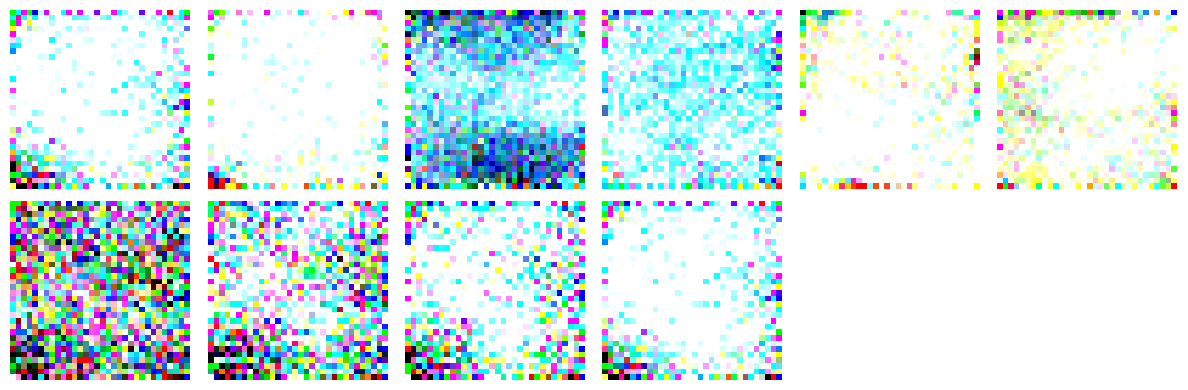

In [23]:

# Sample after training
sample_and_plot(model, scheduler)